In [35]:
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.ml import feature
# Funcionality for classification
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler,OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier, DecisionTreeClassifier,GBTClassifier
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator,RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [36]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [37]:
file_path = "W:/Syracuse/Assignements/BigData/FinalProject/Hospital-Readmission-based-on-Diabetes/Data/"
file_name = "hospital_readmission_cleaned.csv"
diabetes_df = spark.read.csv(get_training_filename('hospital_readmission_cleaned.csv'), header=True, inferSchema=True)
diabetes_df.toPandas().shape

(101766, 35)

In [38]:
categorical_columns= ['race','diag_1','diag_2','diag_3','admission_type_name','dischage_disposition_name','admission_source_name',
               'gender','age','max_glu_serum','A1Cresult','metformin','repaglinide',
               'nateglinide','chlorpropamide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','acarbose',
               'miglitol','insulin','glyburide-metformin','change','diabetesMed']

# The index of string vlaues multiple columns
indexers = [feature.StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("keep") for c in categorical_columns]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline1 = Pipeline(stages=indexers + encoders)
#diabetes_df = pipeline1.fit(diabetes_df).transform(diabetes_df)
#diabetes_df.toPandas().head()


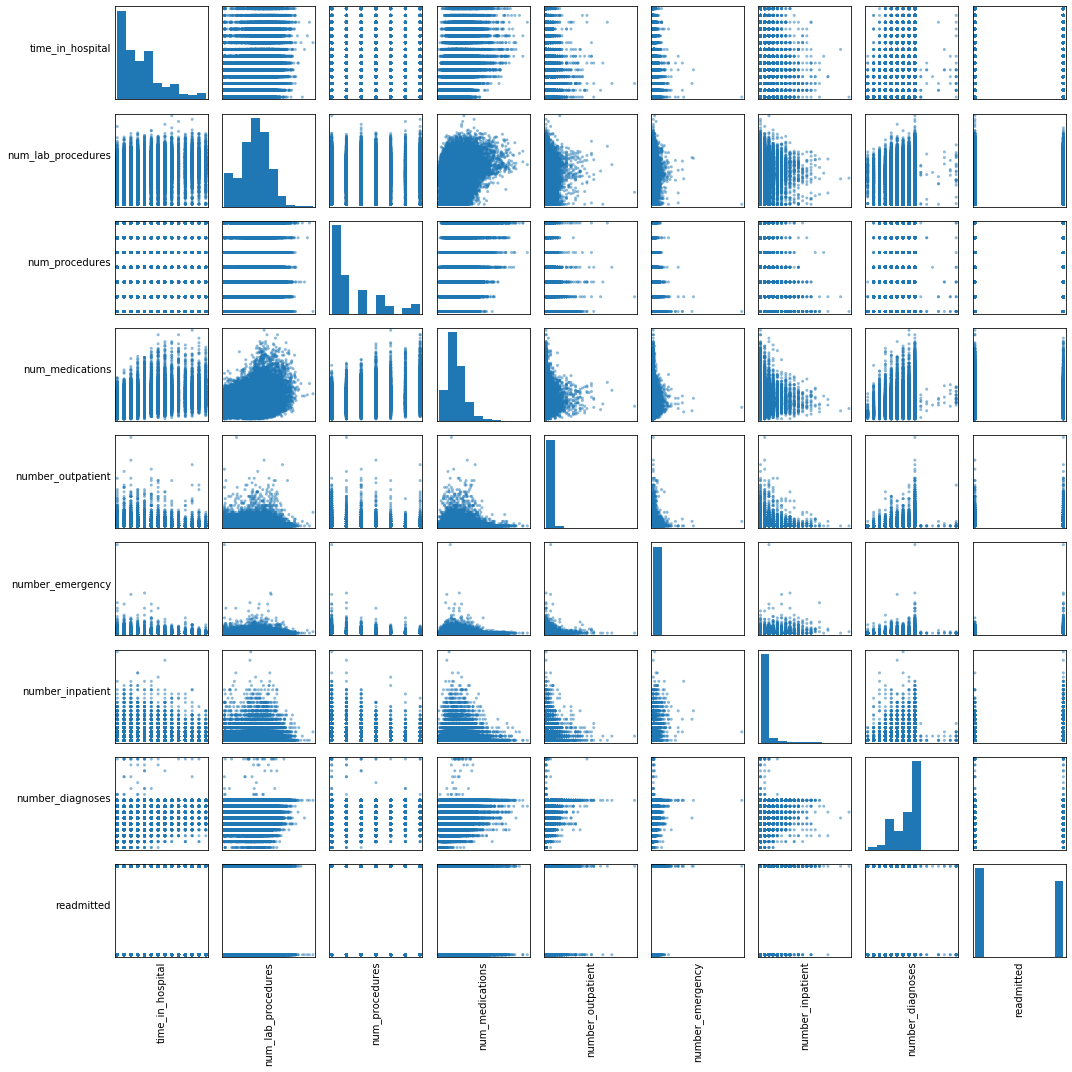

,race,diag_1,diag_2,diag_3,admission_type_name,dischage_disposition_name,admission_source_name,gender,age,time_in_hospital,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,AfricanAmerican,117,348,250,Emergency,Discharged to home,Emergency Room,Male,[20-30),2,...,No,No,No,No,No,No,No,No,No,0
1,AfricanAmerican,135,284,780,Emergency,Discharged to home,Emergency Room,Female,[50-60),5,...,No,No,No,No,No,No,No,No,No,1
2,AfricanAmerican,150,507,276,Emergency,Discharged to home,Emergency Room,Male,[60-70),11,...,No,No,No,No,No,No,No,No,No,0
3,AfricanAmerican,152,560,250,Emergency,Discharged to home,Emergency Room,Male,[40-50),8,...,No,No,No,No,No,Steady,No,Ch,Yes,0
4,AfricanAmerican,153,196,197,Elective,Discharged to home,Physician Referral,Male,[40-50),8,...,No,No,No,No,No,Down,No,Ch,Yes,0


In [39]:
# Split the dataset into training and testing
train, test = diabetes_df.randomSplit([0.6, 0.4], 0)
train, test2 = train.randomSplit([0.6, 0.4], 0)

train.toPandas().shape

numeric_features = [t[0] for t in train.dtypes if t[1] == 'int']
numeric_data = train.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(15, 15));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
plt.tight_layout()
plt.show()

train.toPandas().head()


In [40]:
# build the pipelines
va = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")
sc = feature.StandardScaler(withMean=True, inputCol='features',outputCol = 'zfeatures') 

pipeline2 = Pipeline(stages= [va,sc])
#pipe_model = Pipeline(stages = [VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features"),
#                                feature.StandardScaler(withMean=True, inputCol='features',outputCol = 'zfeatures')])
#train = pipeline2.fit(train).transform(train)

In [41]:
# Logistic regression pipeline
pipe_logit = Pipeline(stages = [pipeline1, pipeline2,LogisticRegression(labelCol='readmitted',featuresCol = 'zfeatures')])

In [42]:
# Fitiing logitstic model
fitted_model = pipe_logit.fit(train)


"\nplt.figure(figsize=(5,5))\nplt.plot([0, 1], [0, 1], 'r--')\nplt.plot(fitted_pipe1.summary.roc.select('FPR').collect(),\n         fitted_pipe1.summary.roc.select('TPR').collect())\nplt.xlabel('FPR')\nplt.ylabel('TPR')\nplt.title('ROC')\nplt.show()\n"

In [43]:
# validate logistic model
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",rawPredictionCol='prediction', labelCol='readmitted')
logit_predicted = fitted_pipe1.transform(test)
evaluator.evaluate(logit_predicted)
#fitted_model.transform(test).select(fn.avg(fn.expr('readmitted = prediction').cast('float'))).show()

0.5961086918646417

In [44]:
# calculate accuracy and recall for logistic model
logit_predicted.select(
(fn.sum(fn.when(fn.col('readmitted')==fn.col('prediction'),1).otherwise(0))/fn.count(fn.col('readmitted'))).alias('Accuracy'),
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))/
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))+ 
fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==0),1).otherwise(0)))).alias('Recall')).show()

+------------------+------------------+
|          Accuracy|            Recall|
+------------------+------------------+
|0.6006265262327027|0.5371587327028904|
+------------------+------------------+



In [45]:
# Random forest pipeline
rf = RandomForestClassifier(labelCol="readmitted", featuresCol="zfeatures", numTrees=10)
pipe_rf = Pipeline(stages = [pipeline1,pipeline2,rf])

In [ ]:
# Fitiing RF model
#fitted_model = pipe_rf.fit(train)
#fitted_model.transform(train).toPandas().head()
grid = (ParamGridBuilder().addGrid(rf.featureSubsetStrategy, ['auto']).addGrid(rf.impurity,['GINI']).addGrid(rf.numTrees, [80]).build())
evaluator = BinaryClassificationEvaluator(labelCol = 'readmitted',metricName = 'areaUnderROC')
cv1 = CrossValidator(estimator=pipe_rf, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv1 = cv1.fit(train)


In [ ]:
# validate random forest model
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",rawPredictionCol='prediction', labelCol='readmitted')
rf_predicted = fitted_cv1.transform(test)
evaluator.evaluate(rf_predicted)
print("Test Area Under ROC: " + str(evaluator.evaluate(rf_predicted)))

In [ ]:
# evaluate accuracy and recall for random forest
rf_predicted.select(
(fn.sum(fn.when(fn.col('readmitted')==fn.col('prediction'),1).otherwise(0))/fn.count(fn.col('readmitted'))).alias('Accuracy'),
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))/
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))+ 
fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==0),1).otherwise(0)))).alias('Recall')).show()

In [ ]:
# explore feature importance with random forest
feature_df = pd.DataFrame(list(zip(train.columns[0:10], fitted_cv1.bestModel.stages[2].featureImportances.toArray())),
           columns = ['feature', 'importance']).sort_values('importance', ascending = False)
feature_df.reset_index(drop=True, inplace=True)
feature_list = feature_df['feature'].head(10)

bestPipeline = fitted_cv1.bestModel
bestModel = bestPipeline.stages[2]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))

# plot top 10 features
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
importances = fitted_model.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [22]:
# Decision tree explorer
dt = DecisionTreeClassifier(labelCol="readmitted", featuresCol="zfeatures")
dt_pipeline = Pipeline(stages=[pipeline1,pipeline2, dt]).fit(train)
dt_prediction = dt_pipeline.transform(test)

In [25]:
# Validate decision tree performance
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",rawPredictionCol='prediction', labelCol='readmitted')
print("Test Area Under ROC: " + str(evaluator.evaluate(dt_prediction)))

Test Area Under ROC: 0.5569429075392875


In [23]:
dt_prediction.select(
(fn.sum(fn.when(fn.col('readmitted')==fn.col('prediction'),1).otherwise(0))/fn.count(fn.col('readmitted'))).alias('Accuracy'),
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))/
(fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==1),1).otherwise(0))+ 
fn.sum(fn.when((fn.col('readmitted')==1) & (fn.col('prediction')==0),1).otherwise(0)))).alias('Recall')).show()

+------------------+-------------------+
|          Accuracy|             Recall|
+------------------+-------------------+
|0.5689795515650823|0.40956218103679826|
+------------------+-------------------+

